In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
base_dir = '/Users/nlarusstone/Documents/corels/bbcache/analysis'
set_dir = f'{base_dir}'
log_dir = f'{set_dir}/logs'
log_suffix = 'out-curious_lb-with_prefix_perm_map-minor-removed=none-max_num_nodes=2000000000-c=0.0100000-v=progress,log-f=1000-i=40'

In [2]:
# utils
def filter_none(arr):
    return arr[arr != np.array(None)]

In [3]:
# 1-116-5000-2
# 1-116-5000-3
# 1-118-5000-1
# 1-120-5000-0

In [4]:
class Label:
    def __init__(self, line_list):
        self.rule_str = line_list[0]
        self.label = self.rule_str.split(':')[1].split('}')[0]
        self.rule_arr = np.array(list(map(int, line_list[1:])))

In [5]:
class Rule(Label):
    def __init__(self, line_list, labels):
        super().__init__(line_list)
        self.labels = labels
        self.accuracy = self.get_accuracy()
        
    def get_accuracy(self):
        acc = 0
        for l in self.labels:
            overlap = l.rule_arr & self.rule_arr
            calc_acc = overlap.sum() / float(self.rule_arr.sum())
            # Choose whichever label gives us better accuracy
            acc = max(acc, calc_acc)
        return acc

In [13]:
class RuleSet:
    def __init__(self, n_rules, n_split):
        fbase = f'1-{n_rules}-5000-{n_split}'
        self.name = fbase
        self.out_file = f'{set_dir}/{fbase}.out'
        self.label_file = f'{set_dir}/{fbase}.label'
        self.minor_file = f'{set_dir}/{fbase}.minor'
        self.log_file = f'{log_dir}/for-{fbase}.{log_suffix}.txt'
        self.opt_file = f'{log_dir}/for-{fbase}.{log_suffix}-opt.txt'
        
        self.labels = None
        self.labels = self._get_rules(self.label_file)
        self.rules = self._get_rules(self.out_file)
        self.opt_rl = self._get_opt_rules()
        
        self.times = self._get_times()
        self.end = self.times[-1]
        
    def _get_times(self):
        df = pd.read_csv(self.log_file)
        return df['total_time'].to_numpy()
    
    def _get_rules(self, file):
        rules = []
        with open(file, 'r') as f:
            for line in f.readlines():
                line_list = line.split()
                rule = Rule(line_list, self.labels) if self.labels else Label(line_list)
                rules.append(rule)
        return rules
    
    def _get_opt_rules(self):
        opt_rules = []
        if os.path.exists(self.opt_file):
            with open(self.opt_file, 'r') as f:
                for l in f.read().split(';')[:-1]:
                    rule = l.rsplit('~', 1)[0]
                    opt_rules.append(rule)
        return opt_rules
    
    def get_acc_arr(self):
        return np.array([r.accuracy for r in self.rules])
    
    def get_supp_arr(self):
        return np.array([r.rule_arr for r in self.rules])
    
    def get_n_wrong_labels(self):
        return (self.get_acc_arr() == None).sum()
    
    def get_rules_per_sample(self):
        ruleset = np.array([r.rule_arr for r in self.rules])
        return ruleset.sum(axis=0)

In [19]:
sixteen_two = RuleSet(116, 2)
sixteen_three = RuleSet(116, 3)
eighteen = RuleSet(118, 1)
twenty = RuleSet(120, 0)
# order in terms of time
rs = [twenty, eighteen, sixteen_two, sixteen_three]

In [20]:
twenties = [RuleSet(120, f'N{i}') for i in range(1, 11)]
rs += twenties

In [29]:
sorted_rs = rs.sort(key=lambda r: r.end)

* Look at the distribution of support for each rule
     * also distribution of accuracy for each rule
* Look at the support for each rule in the optimal rule list
* Relationship between support and accuracy -- 2D plot of accuracy versus support
* How many rules capture each sample?
* Summary statistics:
* Variance of support
* Variance of accuracy per rule

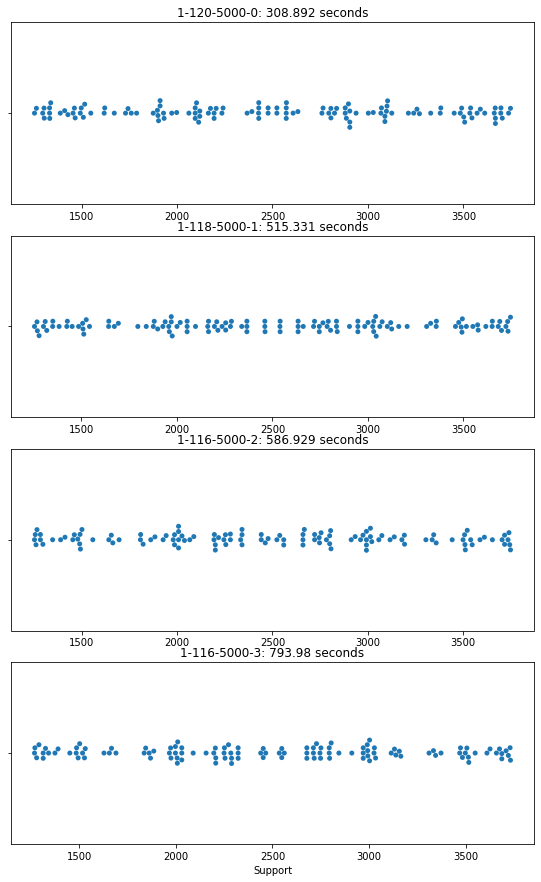

In [111]:
# Distribution of support for eahc rule
fig, axs = plt.subplots(figsize=(8, 12), nrows=4)
fig.tight_layout()
for i, r in enumerate(rs):
    supp_arr = r.get_supp_arr()
    ax = sns.distplot(supp_arr.sum(axis=1), ax=axs[i], rug=True)
    ax.set_title(f'{r.name}: {r.end} seconds')
plt.xlabel('Support')
None

In [21]:
rows = []
for i, r in enumerate(rs):
    acc_arr = r.get_acc_arr()
    supp_arr = r.get_supp_arr().sum(axis=1)
    for i in range(len(supp_arr)):
        row_dict = {'supp': supp_arr[i], 'acc': acc_arr[i], 'time': r.end}
        rows.append(row_dict)
df = pd.DataFrame(rows)

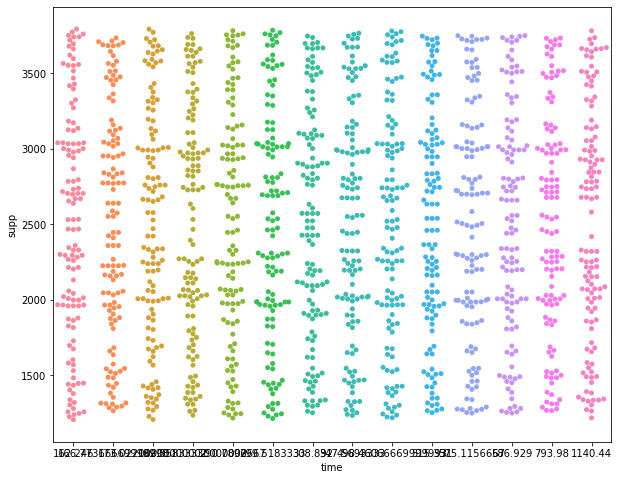

In [22]:
plt.figure(figsize=(10, 8))
sns.swarmplot(x='time', y='supp', data=df)
None

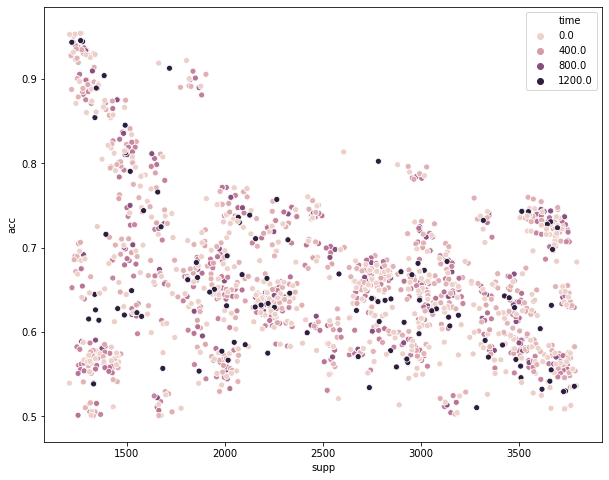

In [23]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='supp', y='acc', hue='time', data=df)
None

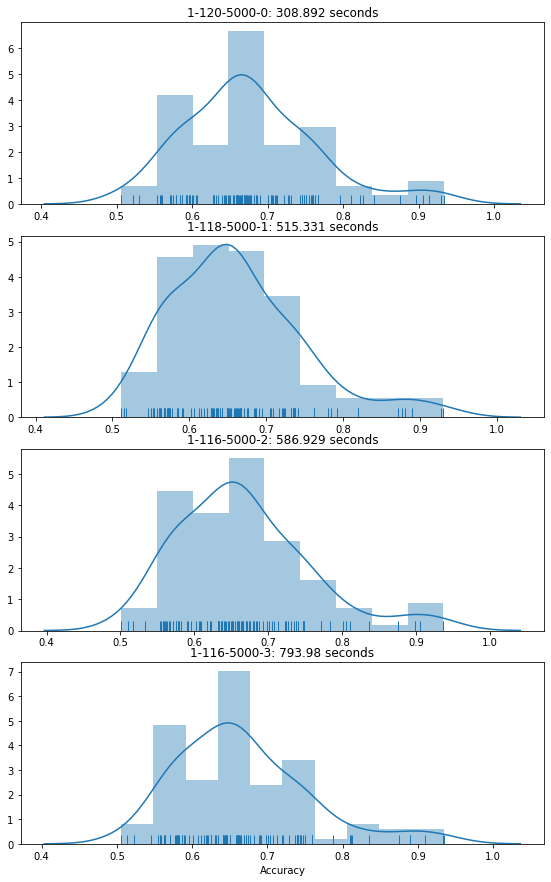

In [42]:
# Distribution of accuracy for eahc rule
fig, axs = plt.subplots(figsize=(8, 12), nrows=4)
fig.tight_layout()
for i, r in enumerate(rs):
    acc_arr = filter_none(r.get_acc_arr())
    ax = sns.distplot(acc_arr, ax=axs[i], rug=True)
    ax.set_title(f'{r.name}: {r.end} seconds')
plt.xlabel('Accuracy')
None

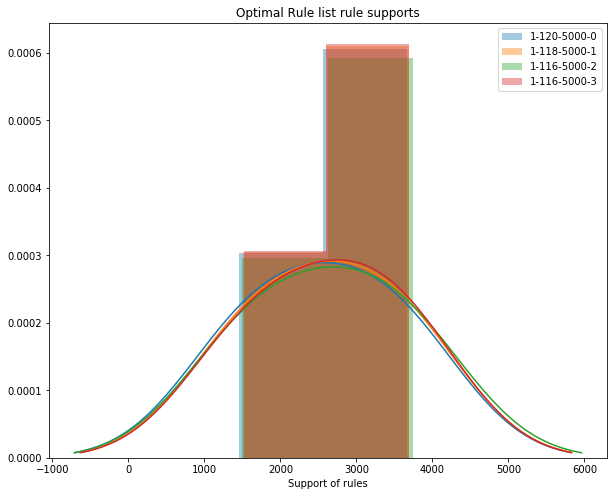

In [72]:
# Look at the support for each rule in the optimal rule list
plt.figure(figsize=(10, 8))
for r in rs:
    supps = []
    for rule in r.opt_rl:
        for ru in r.rules:
            if ru.rule_str == rule:
                supp = ru.rule_arr
                supps.append(supp)
    supps = np.array(supps)
    sns.distplot(supps.sum(axis=1), label=r.name)
plt.title('Optimal Rule list rule supports')
plt.xlabel('Support of rules')
plt.legend()

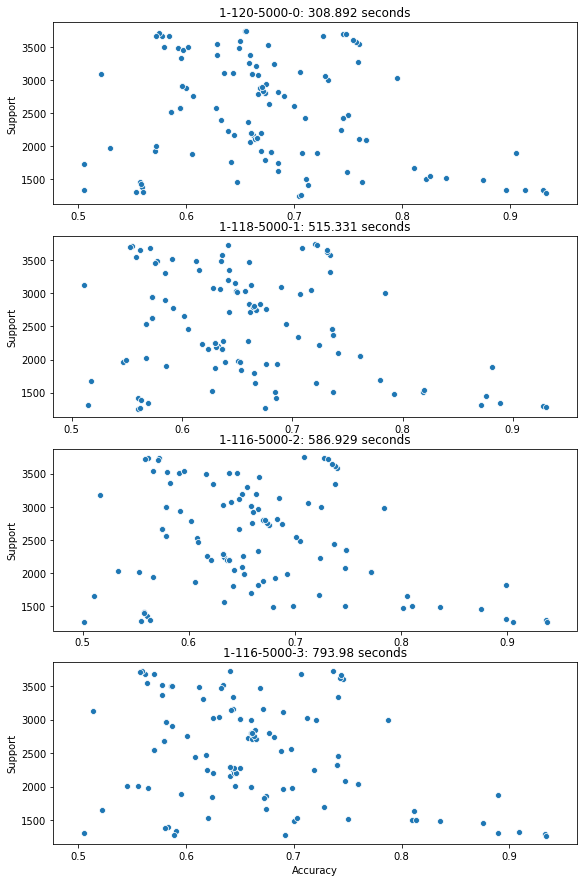

In [175]:
# Relationship between support and accuracy -- 2D plot of accuracy versus support
fig, axs = plt.subplots(figsize=(8, 12), nrows=4)
fig.tight_layout()
for i, r in enumerate(rs):
    acc_arr = filter_none(r.get_acc_arr())
    supp_arr = r.get_supp_arr().sum(axis=1)
    ax = sns.scatterplot(acc_arr, supp_arr, ax=axs[i])
    ax.set_title(f'{r.name}: {r.end} seconds')
    ax.set_ylabel('Support')
plt.xlabel('Accuracy')
None

In [31]:
# How many rules capture each sample?
#fig, axs = plt.subplots(figsize=(8, 12), nrows=4)
#fig.tight_layout()
for i, r in enumerate(rs):
    samp_arr = r.get_rules_per_sample()
    print(f'Runtime: {r.end}, Number of rules per sample: {np.unique(samp_arr)[0]}')
    #ax = sns.distplot(samp_arr, ax=axs[i], rug=True)
    #ax.set_title(f'{r.name}: {r.end} seconds')
#plt.xlabel('Sample support')
None

Runtime: 162.246, Number of rules per sample: 60
Runtime: 166.77366669999998, Number of rules per sample: 60
Runtime: 173.02200000000002, Number of rules per sample: 60
Runtime: 182.55833330000002, Number of rules per sample: 60
Runtime: 290.7896667, Number of rules per sample: 60
Runtime: 299.5183333, Number of rules per sample: 60
Runtime: 308.892, Number of rules per sample: 60
Runtime: 347.5693333, Number of rules per sample: 60
Runtime: 498.46066669999993, Number of rules per sample: 60
Runtime: 515.331, Number of rules per sample: 59
Runtime: 575.1156667, Number of rules per sample: 60
Runtime: 586.929, Number of rules per sample: 58
Runtime: 793.98, Number of rules per sample: 58
Runtime: 1140.44, Number of rules per sample: 60


In [32]:
# Summary statistics:
# variance of accuracy
# variance of support
times = []
supp_vars = []
for i, r in enumerate(rs):
    acc_arr = filter_none(r.get_acc_arr())
    supp_arr = r.get_supp_arr().sum(axis=1)
    acc_var = np.std(acc_arr)
    supp_var = np.std(supp_arr)
    times.append(r.end)
    supp_vars.append(supp_var)
    print(f'Runtime: {r.end}, Accuracy variance: {acc_var}, Support variance: {supp_var}')

Runtime: 162.246, Accuracy variance: 0.08253194391830723, Support variance: 760.979358020527
Runtime: 166.77366669999998, Accuracy variance: 0.08627897166279368, Support variance: 748.6986710286054
Runtime: 173.02200000000002, Accuracy variance: 0.09279952181618766, Support variance: 759.3675548331871
Runtime: 182.55833330000002, Accuracy variance: 0.10101172582712081, Support variance: 759.7455604784187
Runtime: 290.7896667, Accuracy variance: 0.08672081446419662, Support variance: 754.671805047289
Runtime: 299.5183333, Accuracy variance: 0.0843818286421231, Support variance: 759.0239785408627
Runtime: 308.892, Accuracy variance: 0.08776035103384887, Support variance: 755.9721665952171
Runtime: 347.5693333, Accuracy variance: 0.08714772583715252, Support variance: 751.5265575258579
Runtime: 498.46066669999993, Accuracy variance: 0.09049733915991559, Support variance: 765.9411422122025
Runtime: 515.331, Accuracy variance: 0.08650826443727921, Support variance: 743.8460064797903
Runtime

Text(0, 0.5, 'Time')

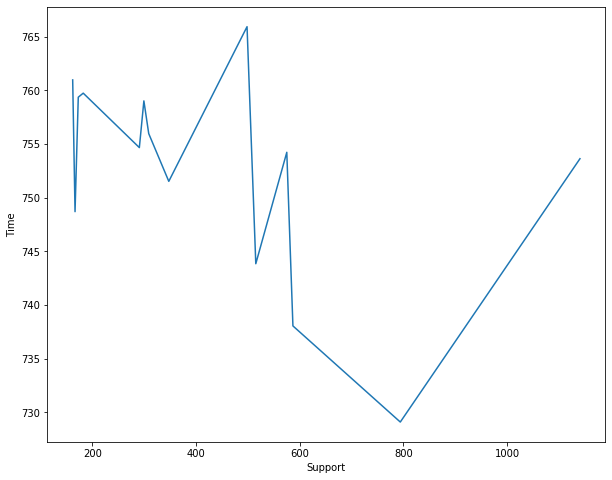

In [35]:
plt.figure(figsize=(10, 8))
sns.lineplot(times, supp_vars)
plt.xlabel('Support')
plt.ylabel('Time')